PANDAS PROJECT

En este proyecto vamos a estudiar un dataset que contiene información acerca de los ataques de tiburones que se han dado en el mundo.

Importaremos los datos, los exploraremos, los limpiaremos y haremos un análisis concreto sobre un tema.

El Principio de Pareto, también conocido como la regla del 80-20, describe el fenómeno estadístico por el que, en cualquier población que contribuye a un efecto común, es una proporción pequeña la que contribuye a la mayor parte del efecto. Ver más aquí: https://es.wikipedia.org/wiki/Principio_de_Pareto

Bien, vamos a comprobar si esto ocurre con los ataques de los tiburones respecto a los países, es decir, veremos si, aproximadamente, el 80% de los ataques se dan en el 20% de los países.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('GSAF5.csv', encoding = "ISO-8859-1")
data.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN


la importación daba un error:
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x92 in position 1: invalid start byte
Busqué este error y di con la solución en stackoverflow, que era añadir 'encoding = "ISO-8859-1"' como argumento al llamar a pd.read_csv

In [3]:
data.shape

(5992, 24)

In [4]:
# vamos a stripear y poner en minúsculas los nombres de las columnas, para que sea más fácil escribirlos
data.columns = data.columns.str.strip().str.lower()
data.columns

Index(['case number', 'date', 'year', 'type', 'country', 'area', 'location',
       'activity', 'name', 'sex', 'age', 'injury', 'fatal (y/n)', 'time',
       'species', 'investigator or source', 'pdf', 'href formula', 'href',
       'case number.1', 'case number.2', 'original order', 'unnamed: 22',
       'unnamed: 23'],
      dtype='object')

In [5]:
# renombramos las columnas "case number" como "id" y "fatal (y/n)" como "fatal" para que sea más cómodo escribirlas
data = data.rename(columns = {"case number":"id", "fatal (y/n)": "fatal"})

In [6]:
# eliminar duplicados
before = len(data)
data = data.drop_duplicates()
after = len(data)
print('Number of duplicate records dropped: ', str(before - after))

Number of duplicate records dropped:  0


In [7]:
#vemos las columnas que tenemos y cuántos valores null tienen
null_cols = data.isnull().sum()
null_cols

id                           0
date                         0
year                         0
type                         0
country                     43
area                       402
location                   496
activity                   527
name                       200
sex                        567
age                       2681
injury                      27
fatal                       19
time                      3213
species                   2934
investigator or source      15
pdf                          0
href formula                 1
href                         3
case number.1                0
case number.2                0
original order               0
unnamed: 22               5991
unnamed: 23               5990
dtype: int64

In [8]:
# eliminamos las columnas que contengan más de 2500 nulls
print(data.shape)
drop_cols = list(null_cols[null_cols > 2500].index)
data = data.drop(drop_cols, axis=1)
print(data.shape)

(5992, 24)
(5992, 19)


In [9]:
#nos quedamos solo con los datos posteriores a 1920
data = data[data.year >= 1920]
data.shape

(5030, 19)

In [10]:
# nos quedamos con las columnas que nos interesan
data = data[["id", "year", "type", "country", "activity", "fatal"]]
data.shape

(5030, 6)

In [11]:
# comprobamos nulls
null_cols = data.isnull().sum()
null_cols

id            0
year          0
type          0
country      21
activity    395
fatal         8
dtype: int64

In [12]:
# eliminamos las filas que contienen nulls
data = data[data.country.notnull()]
data = data[data.activity.notnull()]
data = data[data.fatal.notnull()]
data.shape

(4611, 6)

In [13]:
# comprobamos que ya no tenemos nulls en ningún campo
null_cols = data.isnull().sum()
null_cols

id          0
year        0
type        0
country     0
activity    0
fatal       0
dtype: int64

In [14]:
# vamos a cambiar el orden de las columnas, para ponerlas a nuestro gusto
column_order = ["id", "year", "country", "type", "activity", "fatal" ]
data = data[column_order]
data.head()

,id,year,country,type,activity,fatal
0,2016.09.18.c,2016,USA,Unprovoked,Surfing,N
1,2016.09.18.b,2016,USA,Unprovoked,Surfing,N
2,2016.09.18.a,2016,USA,Unprovoked,Surfing,N
3,2016.09.17,2016,AUSTRALIA,Unprovoked,Surfing,N
4,2016.09.15,2016,AUSTRALIA,Unprovoked,Surfing,N


In [15]:
# comprobamos si hay algún id duplicado. aquí tenemos que contar por una variable que no sea el id. cogemos year, ya que hemos visto que no tiene nulls
data.groupby("id").count()[["year"]].sort_values("year", ascending=False).head(11)

,year
id,
2013.10.05,2
1966.12.26,2
1923.00.00.a,2
2006.09.02,2
1962.06.11.b,2
2014.08.02,2
2009.12.18,2
1980.07.00,2
1990.05.10,2


In [16]:
"""
vamos a asignar ids únicos a los que están duplicados
la siguiente función evalúa todos los ids y, en caso de que, a la hora de evaluar uno de ellos,
ya exista otro registro con ese mismo id, le pone una "a" al final, para diferenciarlo.
"""
def duplicates(id_column):
    new_id_column = []
    for i in range(len(id_column)):
        new_id = str(id_column[i])
        if new_id not in new_id_column:
            new_id_column.append(new_id)
        else:
            new_id_column.append(new_id + "a")
    return new_id_column

In [17]:
# aplicamos la función duplicates para la columna id
data["id"] = duplicates(list(data["id"]))

In [18]:
# comprobamos ahora que solo existe un registro para cada id
data.groupby("id").count()[["year"]].sort_values("year", ascending=False).head(14)

,year
id,
1920.00.00.a,1
2006.09.30,1
2002.09.27.a,1
2002.09.21.b,1
2002.09.21.a,1
2002.09.16.b,1
2002.09.16.a,1
2002.09.13,1
2002.09.09,1


In [19]:
# vemos el contenido que existe en el campo "type"
data.groupby("type").count()[["id"]]

,id
type,
Boat,172
Boating,65
Invalid,321
Provoked,473
Sea Disaster,157
Unprovoked,3423


In [20]:
# unificar type Boat y Boating
data = data.replace({'type': "Boating"}, "Boat")

In [21]:
# comprobación
data.groupby("type").count()[["id"]]

,id
type,
Boat,237
Invalid,321
Provoked,473
Sea Disaster,157
Unprovoked,3423


In [22]:
# vemos cuáles son los países en los que más ataques se han dado en los años tenidos en cuenta
data["country"] = data["country"].str.strip().str.title()
countries = data.groupby("country").count()[["id"]].sort_values("id", ascending = False)
countries.head(10)

,id
country,
Usa,1800
Australia,949
South Africa,483
Papua New Guinea,106
Brazil,92
Bahamas,85
New Zealand,80
Mexico,63
Reunion,50


In [23]:
# vemos el contenido que hay en el campo "fatal"
data.groupby("fatal").count()[["id"]].sort_values("id", ascending = False)

,id
fatal,
N,3640
Y,930
UNKNOWN,35
N,6


In [24]:
# vamos a aplicar strip() en la columna "fatal" para unificar datos
data["fatal"] = data["fatal"].str.strip()
# además, vemos que hay un registro con "F". entendemos que se refiere a fatal, así que lo cambiamos por "Y"
data = data.replace({"fatal": "F"}, "Y")

In [25]:
# comprobación
data.groupby("fatal").count()[["id"]].sort_values("id", ascending = False)

,id
fatal,
N,3646
Y,930
UNKNOWN,35


In [26]:
# vamos a aplicar .strip() y .lower() en la columna "activity" para unificar datos
data["activity"] = data["activity"].str.strip().str.lower()
data.groupby("activity").count()[["id"]].sort_values("id", ascending = False).head()

,id
activity,
surfing,903
swimming,686
fishing,349
spearfishing,322
wading,132


In [27]:
# ahora vamos a agrupar las activities en unos pocos grupos
def group_act(e):
    if "fish" in e:
        return "Fishing"
    elif "surf" in e:
        return "Surfing"
    elif "swim" in e:
        return "Swimming"
    elif "wading" in e or "wade" in e:
        return "Wading"
    elif "diving" in e or "dive" in e:
        return "Diving"
    elif "stand" in e:
        return "Standing"
    elif "board" in e:
        return "Boarding"
    elif "bath" in e:
        return "Bathing"
    elif "snorkel" in e:
        return "Snorkeling"
    else:
        return "Others"

In [28]:
data["activity"] = data["activity"].map(group_act)

In [29]:
data.groupby("activity").count()[["id"]].sort_values("id", ascending = False)

,id
activity,
Surfing,1145
Fishing,1062
Swimming,816
Others,618
Diving,411
Boarding,169
Wading,142
Standing,119
Snorkeling,77


In [30]:
data = data.reset_index(drop = True)

In [31]:
# añadimos columna con "20%", que dirá si los países se encuentran entre el 20% de los mismos que reciben más ataques
data["country20"] = data["country"]

In [32]:
# vamos a coger la lista "countries" (países ordenados de más ataques a menos ataques)
# llamamos countries20 al 20% de los países con más ataques (los primeros x países, donde x es el 20% de los mismos)
# llamamos countries80 al resto de países
# las hacemos listas para luego poder utilizarlas en el replace (transpose() las convierte en listas)
countries20 = countries[:(len(countries))//5].transpose()
countries20col = list(countries20.columns)
countries80 = countries[(len(countries))//5:].transpose()
countries80col = list(countries80.columns)

In [33]:
# en la nueva columna, sustituímos los países del 20% por un "Y" y el resto con un "N".
data = data.replace({"country20": countries20col}, "Y")
data = data.replace({"country20": countries80col}, "N")
data.head()

,id,year,country,type,activity,fatal,country20
0,2016.09.18.c,2016,Usa,Unprovoked,Surfing,N,Y
1,2016.09.18.b,2016,Usa,Unprovoked,Surfing,N,Y
2,2016.09.18.a,2016,Usa,Unprovoked,Surfing,N,Y
3,2016.09.17,2016,Australia,Unprovoked,Surfing,N,Y
4,2016.09.15,2016,Australia,Unprovoked,Surfing,N,Y


In [34]:
# hacemos una tabla dinámica para ver, por año, la cantidad de ataques en los países del 20% y en los del 80%
table = pd.pivot_table(data, values = "id", index="year",columns=["country20"], aggfunc=len, fill_value=0)
table.head()

country20,N,Y
year,,
1920,1,13
1921,2,7
1922,3,18
1923,1,18
1924,1,18


In [35]:
# añadimos 3 columnas más:
# una que sean los ataques totales por año, otra con el porcentaje de ataques en países del 20%
# y otra con el porcentaje de ataques en países del 80%
table["total"] = table["Y"] + table["N"]
table["N%"] = table["N"] / table["total"] * 100
table["Y%"] = table["Y"] / table["total"] * 100
table.head()

country20,N,Y,total,N%,Y%
year,,,,,
1920,1,13,14,7.142857,92.857143
1921,2,7,9,22.222222,77.777778
1922,3,18,21,14.285714,85.714286
1923,1,18,19,5.263158,94.736842
1924,1,18,19,5.263158,94.736842


In [36]:
# creamos un nuevo DataFrame que contenga únicamente las columnas de los porcentajes
table20 = pd.DataFrame()
table20["Y%"] = table["Y%"]
table20["N%"] = table["N%"]
table20.head()

,Y%,N%
year,,
1920,92.857143,7.142857
1921,77.777778,22.222222
1922,85.714286,14.285714
1923,94.736842,5.263158
1924,94.736842,5.263158


In [37]:
# calculamos la media del porcentaje de ataques sufridos en el primer 20% de los países
table20["Y%"].mean()

89.84258226456966

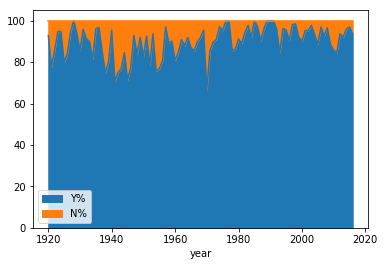

In [38]:
# representamos un gráfico que muestra los porcentajes que representan los ataques en países del 20% y del 80%
table20.plot.area()
plt.plot()
plt.show()

Vemos que la media del porcentaje de ataques sufridos en los países del 20% desde 1920 es del 89.84%, muy superior al 80% que dice el Principio de Pareto. Esto puede ser debido a que es posible que los países que más ataques reciben hayan registrado un mayor porcentaje de los mismos, por tenerlos más en cuenta, por tener mejores medios para hacerlo, etc.

In [39]:
# vamos a exportar el dataframe limpio y también el que hemos usado para el gráfico:
data.to_csv("data.csv")
table.to_csv("table.csv")